In [5]:
import numpy as np
import matplotlib.pyplot as plt
import re
import os

from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.preprocessing import sequence
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense, Flatten

In [16]:
root = "imdb/aclImdb"
   
splits = ['train', 'test']
labels = ['pos', 'neg']
paths = ["%s/%s/%s" %(root, split, label ) for split in splits for label in labels]

files=[]
for path in paths:
    files += ['%s/%s' %(path,x) for x in os.listdir(path)]
    
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def readFile(f):
    with open(f) as fin:
        return remove_tags(" ".join(fin.readlines()))
    
input_label = ([1] * 12500 + [0] * 12500) * 2
input_text  = [readFile(f) for f in files]


In [17]:
train_size = 25000
num_words = 10000
tok = Tokenizer(num_words)
tok.fit_on_texts(input_text[:train_size])
maxlen=300

In [18]:
X_train = tok.texts_to_sequences(input_text[:train_size])
y_train = input_label[:train_size]

X_test  = tok.texts_to_sequences(input_text[train_size:])
y_test  = input_label[train_size:]

X_train = sequence.pad_sequences(X_train, maxlen=maxlen)
X_test  = sequence.pad_sequences(X_test,  maxlen=maxlen)

In [19]:
import w2v
embeddings = w2v.Word2VecModel('GoogleNews-vectors-negative300.bin')
vocab_dim = 300 # dimensionality of your word vectors


In [20]:
embedding_weights = np.zeros((num_words,vocab_dim))
inverted_index = {v:k for k,v in tok.word_index.iteritems()}
for i in xrange(1, num_words):
    embedding_weights[i] = embeddings.lookup(inverted_index[i], False)


In [24]:
def train(weights, batch_size = 32, nb_epoch = 5):
    model = Sequential()

    model.add(Embedding(num_words,
                        vocab_dim,
                        input_length=maxlen, weights=weights #, dropout=0.2
                       ))

    model.add(GlobalAveragePooling1D())
    

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    history = model.fit(X_train, y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_test, y_test), verbose=1)
    return history

useW2V = False
weights = [emdedding_weights] if useW2V else None
    
history = train(None, batch_size=32, nb_epoch=3)
print(history.history['val_acc'][-1])

#history = train(weights, batch_size=32, nb_epoch=1)
#print(history.history['val_acc'][-1])



Train on 25000 samples, validate on 25000 samples
Epoch 1/3
25000/25000 [==============================] - 81s - loss: 0.4873 - acc: 0.7921 - val_loss: 0.3503 - val_acc: 0.8584
Epoch 2/3
25000/25000 [==============================] - 84s - loss: 0.2758 - acc: 0.8954 - val_loss: 0.2912 - val_acc: 0.8820
Epoch 3/3
25000/25000 [==============================] - 90s - loss: 0.2173 - acc: 0.9207 - val_loss: 0.2798 - val_acc: 0.8861
0.88612


['acc', 'loss', 'val_acc', 'val_loss']


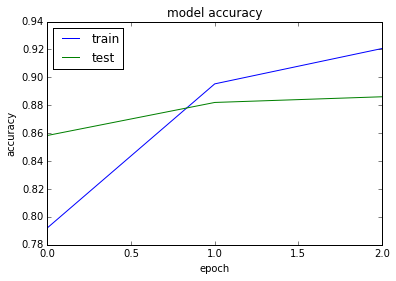

In [25]:
import matplotlib.pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
